In [1]:
import os
import gc
import csv
import json
import pickle
import pprint
import traceback
import numpy as np
import supervision as sv
from tqdm import tqdm
import torch.nn.functional as F
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.draw import polygon_perimeter


from groundingdino.util.inference import load_model, load_image, load_copped_image, predict, annotate

from id_to_class import bdd100k_det as id2class
from id_to_class import bdd100k_det_name2RGB as name2RGB
from id_to_class import bdd100k_det_name2white as name2white
from id_to_class import bdd100k_det_name2red as name2red

name2blue = {i: (0,191,255) for i in id2class.values()}

class2id = {v: k for k, v in id2class.items()}
pp = pprint.PrettyPrinter(indent=4)


/home/belay/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bdd100k_all = {
    0: "pedestrian",
    1: "rider",
    2: "car",
    3: "truck",
    4: "bus",
    5: "train",
    6: "motorcycle",
    7: "bicycle",
    8: "traffic light",
    9: "traffic sign"
}

cwd = os.getcwd()
pp = pprint.PrettyPrinter(indent=4)


# weight_name_acronym ='swinb'
# weight_name = 'groundingdino_swinb_cogcoor.pth'
# conf_path = f'{home}/groundingdino/config/GroundingDINO_SwinB.cfg.py'

weight_name_acronym ='swint'
weight_name = "groundingdino_swint_ogc.pth"
conf_path = f'{cwd}/config/GroundingDINO_SwinT_OGC.py'

weight_path = f'{cwd}/weights/{weight_name}'


print(weight_path, "; exist:", os.path.isfile(weight_path))
print(conf_path, "; exist:", os.path.isfile(conf_path))


model = load_model(conf_path, weight_path)



/home/belay/Documents/github_others/gDINO/notebooks/weights/groundingdino_swint_ogc.pth ; exist: True
/home/belay/Documents/github_others/gDINO/notebooks/config/GroundingDINO_SwinT_OGC.py ; exist: True


/home/belay/miniconda3/envs/gDINO/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/home/belay/miniconda3/envs/gDINO/lib/python3.8/site-packages/transformers/modeling_utils.py:429: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
/home/belay/miniconda3/envs/gDINO/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/belay/miniconda3/envs/gDINO/lib/python3.8/site-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in 

In [27]:
def xywh2ratio(img_w, img_h, bbox):

    x, y, w, h = bbox
    x_center = x + w/2.0
    y_center = y + h/2.0
    x_center_ratio = x_center/img_w * 1.0
    y_center_ratio = y_center/img_h * 1.0
    w_ratio = w/img_w * 1.0
    h_ratio = h/img_h * 1.0


    return [x_center_ratio, y_center_ratio, w_ratio, h_ratio]


def ratio2x1y1x2y2(img_w, img_h, bbox):
    
        x_center_ratio, y_center_ratio, w_ratio, h_ratio = bbox
    
        x_center = x_center_ratio * img_w
        y_center = y_center_ratio * img_h
        w = w_ratio * img_w
        h = h_ratio * img_h
    
        x1 = x_center - w/2.0
        y1 = y_center - h/2.0
        x2 = x_center + w/2.0
        y2 = y_center + h/2.0
    
        return [x1, y1, x2, y2]



def draw_bboxes(img, gt_bboxes, gt_labels, gt_labels_des, pred_labels, pred_labels_des, name2RGB, isshow, isfont, title):

    for idx, (gt_bbox, gt_label, gt_label_des, pred_label, pred_label_des) in enumerate(zip(gt_bboxes, gt_labels, gt_labels_des, pred_labels, pred_labels_des)):

        gt_bbox = ratio2x1y1x2y2(img.shape[1], img.shape[0], gt_bbox)

        ymin, xmin, ymax, xmax = [int(i) for i in gt_bbox]
        r = [xmin, xmax, xmax, xmin, xmin]
        c = [ymax, ymax, ymin, ymin, ymax]
        rr, cc = polygon_perimeter(r, c, img.shape)

        rgb = name2RGB[gt_label_des]
        img[rr, cc ,0] = rgb[0]
        img[rr, cc ,1] = rgb[1]
        img[rr, cc ,2] = rgb[2]

        if isfont is True:
            font = cv2.FONT_HERSHEY_SIMPLEX
            text_org = (ymin, xmin-2)

            if gt_label_des == 'traffic sign':
                gt_label_des = 'sign'
            elif gt_label_des == 'traffic light':
                gt_label_des = 'light'

            labeltext = f'{gt_label_des}'
            cv2.putText(img, labeltext, text_org, font, 0.5, rgb, 1)

    if isshow is True:
        dpi = 150
        fig = plt.figure(dpi=dpi, figsize=(7,9))
        plt.imshow(img)
        plt.title(title)
    
    return img




objs = [
            {   'anno': {   'area': 236133.4030558433,
                'bbox': [393.353004, 119.102029, 536.81189, 439.88109699999995],
                'category_id': 2, # car
                'id': 168648,
                'ignore': 0,
                'image_id': 9101,
                'iscrowd': 0,
                'scalabel_id': '253640'},
                'image': {   'file_name': 'c8476b52-a66aa1c5.jpg',
                            'height': 720,
                            'id': 9101,
                            'width': 1280}},
            {   'anno': {   'area': 19080.798378071246,
                    'bbox': [   187.312372,
                                364.499748,
                                157.93739200000002,
                                120.81241899999998],
                    'category_id': 2, # car
                    'id': 169870,
                    'ignore': 0,
                    'image_id': 9168,
                    'iscrowd': 0,
                    'scalabel_id': '255442'},
                'image': {   'file_name': 'c876f8b1-f19a1697.jpg',
                            'height': 720,
                            'id': 9168,
                            'width': 1280}},
            {   'anno': {   'area': 4736.960604113478,
                    'bbox': [   943.373934,
                                254.238634,
                                62.18709899999999,
                                76.17272200000002],
                    'category_id': 7, # bicycle
                    'id': 146994,
                    'ignore': 0,
                    'image_id': 7915,
                    'iscrowd': 0,
                    'scalabel_id': '220634'},
                'image': {   'file_name': 'c573ac02-6c5f037e.jpg',
                            'height': 720,
                            'id': 7915,
                            'width': 1280}},
            {   'anno': {   'area': 4294.900491462622,
                    'bbox': [   1053.893205,
                                291.600081,
                                33.144890999999916,
                                129.579563],
                    'category_id': 0, # pedestrian
                    'id': 70009,
                    'ignore': 0,
                    'image_id': 3739,
                    'iscrowd': 0,
                    'scalabel_id': '104727'},
                'image': {   'file_name': 'bb6f381e-02e9cc6b.jpg',
                            'height': 720,
                            'id': 3739,
                            'width': 1280}},
            {   'anno': {   'area': 1638.1902116867439,
                    'bbox': [   406.370361,
                                56.315185,
                                28.031289000000015,
                                58.441486999999995],
                    'category_id': 8, # traffic light
                    'id': 2992,
                    'ignore': 0,
                    'image_id': 170,
                    'iscrowd': 0,
                    'scalabel_id': '4570'},
                'image': {   'file_name': 'b230132b-ff8f2719.jpg',
                            'height': 720,
                            'id': 170,
                            'width': 1280}}]

################################
#                     Choose object from 0-4                    #
################################
obj = objs[2]

    
image_dir = f'{cwd}/imgs'
imgname = obj['image']['file_name']
imgpath = f"{image_dir}/{imgname}"
img_shape = (obj['image']['width'], obj['image']['height'])

print(f'imgname={imgname}')
print(f'imgpath={imgpath}')

pp.pprint(obj)

assert os.path.isfile(imgpath), f'Not existed! {imgpath}'


img = np.array(Image.open(imgpath))

label_gt = obj['anno']['category_id']
label_gt_des = id2class[label_gt]


################################
#                    Choose bbox deviation                    #
################################
# BBox Deviation
# obj['anno']['bbox'][0] = obj['anno']['bbox'][0] -10
# obj['anno']['bbox'][1] = obj['anno']['bbox'][1] +5

# BBox 80% smaller
obj['anno']['bbox'][2] = obj['anno']['bbox'][2] * 1.1
obj['anno']['bbox'][3] = obj['anno']['bbox'][3] * 0.8





imgname=c573ac02-6c5f037e.jpg
imgpath=/home/belay/Documents/github_others/gDINO/notebooks/imgs/c573ac02-6c5f037e.jpg
{   'anno': {   'area': 4736.960604113478,
                'bbox': [   943.373934,
                            254.238634,
                            62.18709899999999,
                            76.17272200000002],
                'category_id': 7,
                'id': 146994,
                'ignore': 0,
                'image_id': 7915,
                'iscrowd': 0,
                'scalabel_id': '220634'},
    'image': {   'file_name': 'c573ac02-6c5f037e.jpg',
                 'height': 720,
                 'id': 7915,
                 'width': 1280}}


In [28]:
bbox = xywh2ratio(obj['image']['width'], obj['image']['height'], obj['anno']['bbox'])

TEXT_PROMPT = label_gt_des
BOX_TRESHOLD = 0.2
TEXT_TRESHOLD = 0.15


image_source, image = load_image(imgpath)

pred_bboxes, pred_bboxes_unmasked, logits, phrases, sub_tokens, token_logits, token_logits_raw, class_logits, class_logits_raw, mask, tokenidx2class, class2tokenidx = predict(
                    model=model, 
                    bboxes = torch.tensor([bbox]),
                    image=image, 
                    caption=TEXT_PROMPT, 
                    box_threshold=BOX_TRESHOLD, 
                    text_threshold=TEXT_TRESHOLD
                )

/home/belay/miniconda3/envs/gDINO/lib/python3.8/site-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/belay/miniconda3/envs/gDINO/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Origin bbox=[0.7637319050390625, 0.3954273927777778, 0.053442038203125, 0.0846363577777778]
Refined bbox=[[0.7628362  0.40560564 0.05172603 0.10202582]]
label_gt_des=bicycle


<Figure size 1050x600 with 0 Axes>

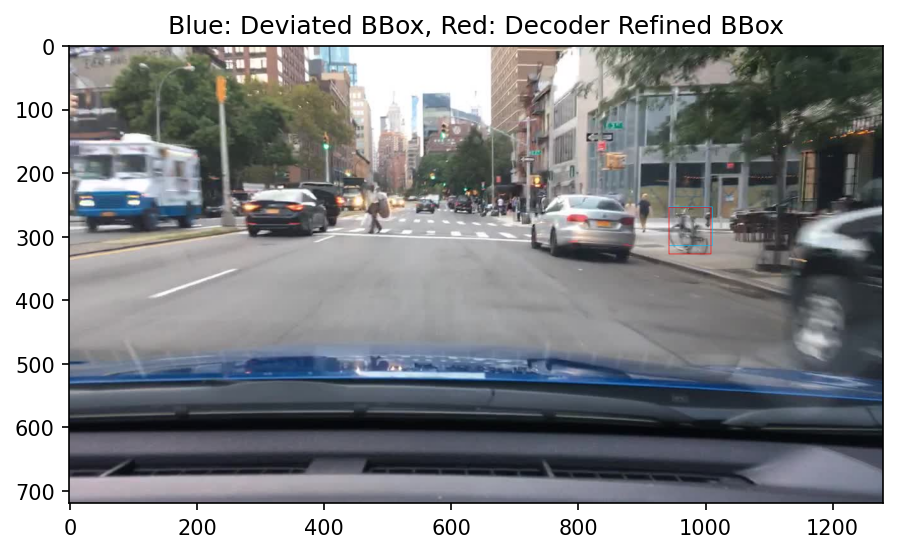

In [29]:
deviated_bbox = np.array([bbox])
pred_bbox =  pred_bboxes.detach().cpu().numpy()
print(f'Origin bbox={bbox}')
print(f'Refined bbox={pred_bbox}')
print(f'label_gt_des={label_gt_des}')

labels_pred = class_logits.max(dim=1).indices.detach().cpu().tolist()

dpi = 150
fig = plt.figure(dpi=dpi, figsize=(7,4))

isshow, isfont = False, False
img_with_bbox = draw_bboxes(img, deviated_bbox, [label_gt], [label_gt_des], [[]], [[]], name2blue, isshow, isfont, '')

isshow, isfont = True, False
title = 'Blue: Deviated BBox, Red: Decoder Refined BBox'
img_with_bbox2 = draw_bboxes(img_with_bbox, pred_bbox, [label_gt], [label_gt_des], [[]], [[]], name2red, isshow, isfont, title)

